# SF Bay Area Bike Share using XGBoost

We are going to use XGBoost to predict availability of bikes at various stations

First we update the local version of Pandas before we import it

In [188]:
! pip install --upgrade pandas --user

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


Next we import the required libraries and set up the figure parameters

In [197]:
#Importing the required libraries and setting up the figure parameters
import pandas as pd
import s3fs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from matplotlib import rcParams
dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]
rcParams['figure.figsize'] = (12, 9)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15 
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="white"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 1
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

In [189]:
print(pd.__version__)

1.3.4


Copy the datasets we will be using to your notebook instance

In [199]:
! aws s3 cp s3://example-lab-artifacts/geospatial/dataset/ . --recursive

download: s3://example-lab-artifacts/geospatial/dataset/station.csv to ./station.csv
download: s3://example-lab-artifacts/geospatial/dataset/weather.csv to ./weather.csv
download: s3://example-lab-artifacts/geospatial/dataset/trip.csv to ./trip.csv
download: s3://example-lab-artifacts/geospatial/dataset/status.csv to ./status.csv


Now we load the trips made and list of stations datasets

In [200]:
trips_df = pd.read_csv('./trip.csv')
stations_df = pd.read_csv('./station.csv')

Lets take a look at the stations dataset

In [6]:
stations_df.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [203]:
stations_df.dtypes

id                    int64
name                 object
lat                  object
long                 object
dock_count            int64
city                 object
installation_date    object
dtype: object

In [202]:
stations_df["lat"] = stations_df["lat"].apply(lambda x:str(x))
stations_df["long"] = stations_df["long"].apply(lambda x:str(x))

In [10]:
stations_df.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.8932,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [11]:
trips_df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [12]:
trips_df['start_date'] = pd.to_datetime(trips_df['start_date'])
trips_df['end_date'] = pd.to_datetime(trips_df['end_date'])

In [13]:
start_station_info = stations_df[["id","lat","long"]]
start_station_info.columns = ["start_station_id","start_lat","start_long"]
end_station_info = stations_df[["id","lat","long"]]
end_station_info.columns = ["end_station_id","end_lat","end_long"]
trips_df = trips_df.merge(start_station_info,on="start_station_id")
trips_df = trips_df.merge(end_station_info,on="end_station_id")

In [14]:
trips_df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,start_lat,start_long,end_lat,end_long
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,37.774814,-122.418954,37.774814,-122.418954
1,4760,113,2013-08-29 17:01:00,South Van Ness at Market,66,2013-08-29 17:03:00,South Van Ness at Market,66,553,Subscriber,94103,37.774814,-122.418954,37.774814,-122.418954
2,5070,168,2013-08-29 21:43:00,South Van Ness at Market,66,2013-08-29 21:46:00,South Van Ness at Market,66,598,Subscriber,94115,37.774814,-122.418954,37.774814,-122.418954
3,4584,262,2013-08-29 14:17:00,South Van Ness at Market,66,2013-08-29 14:21:00,South Van Ness at Market,66,587,Subscriber,94612,37.774814,-122.418954,37.774814,-122.418954
4,4079,995,2013-08-29 09:35:00,South Van Ness at Market,66,2013-08-29 09:52:00,South Van Ness at Market,66,327,Subscriber,94102,37.774814,-122.418954,37.774814,-122.418954


In [15]:
plot_dict = dict()
for index,row in trips_df.iterrows():
    start_lat = row['start_lat']
    start_long = row['start_long']
    end_lat = row['end_lat']
    end_long = row['end_long']
    key = str(start_lat)+'_'+str(start_long)+'_'+str(end_lat)+'_'+str(end_long)
    if key in plot_dict:
        plot_dict[key] += 1
    else:
        plot_dict[key] = 1

In [16]:
start_lat = []
start_long = []
end_lat = []
end_long = []
nb_trips = []
for key,value in plot_dict.items():
    start_lat.append(float(key.split('_')[0]))
    start_long.append(float(key.split('_')[1]))
    end_lat.append(float(key.split('_')[2]))
    end_long.append(float(key.split('_')[3]))
    nb_trips.append(int(value))

In [17]:
temp_df = pd.DataFrame({"start_lat":start_lat,"start_long":start_long,"end_lat":end_lat,"end_long":end_long,"nb_trips":nb_trips})

In [18]:
temp_df.dtypes

start_lat     float64
start_long    float64
end_lat       float64
end_long      float64
nb_trips        int64
dtype: object

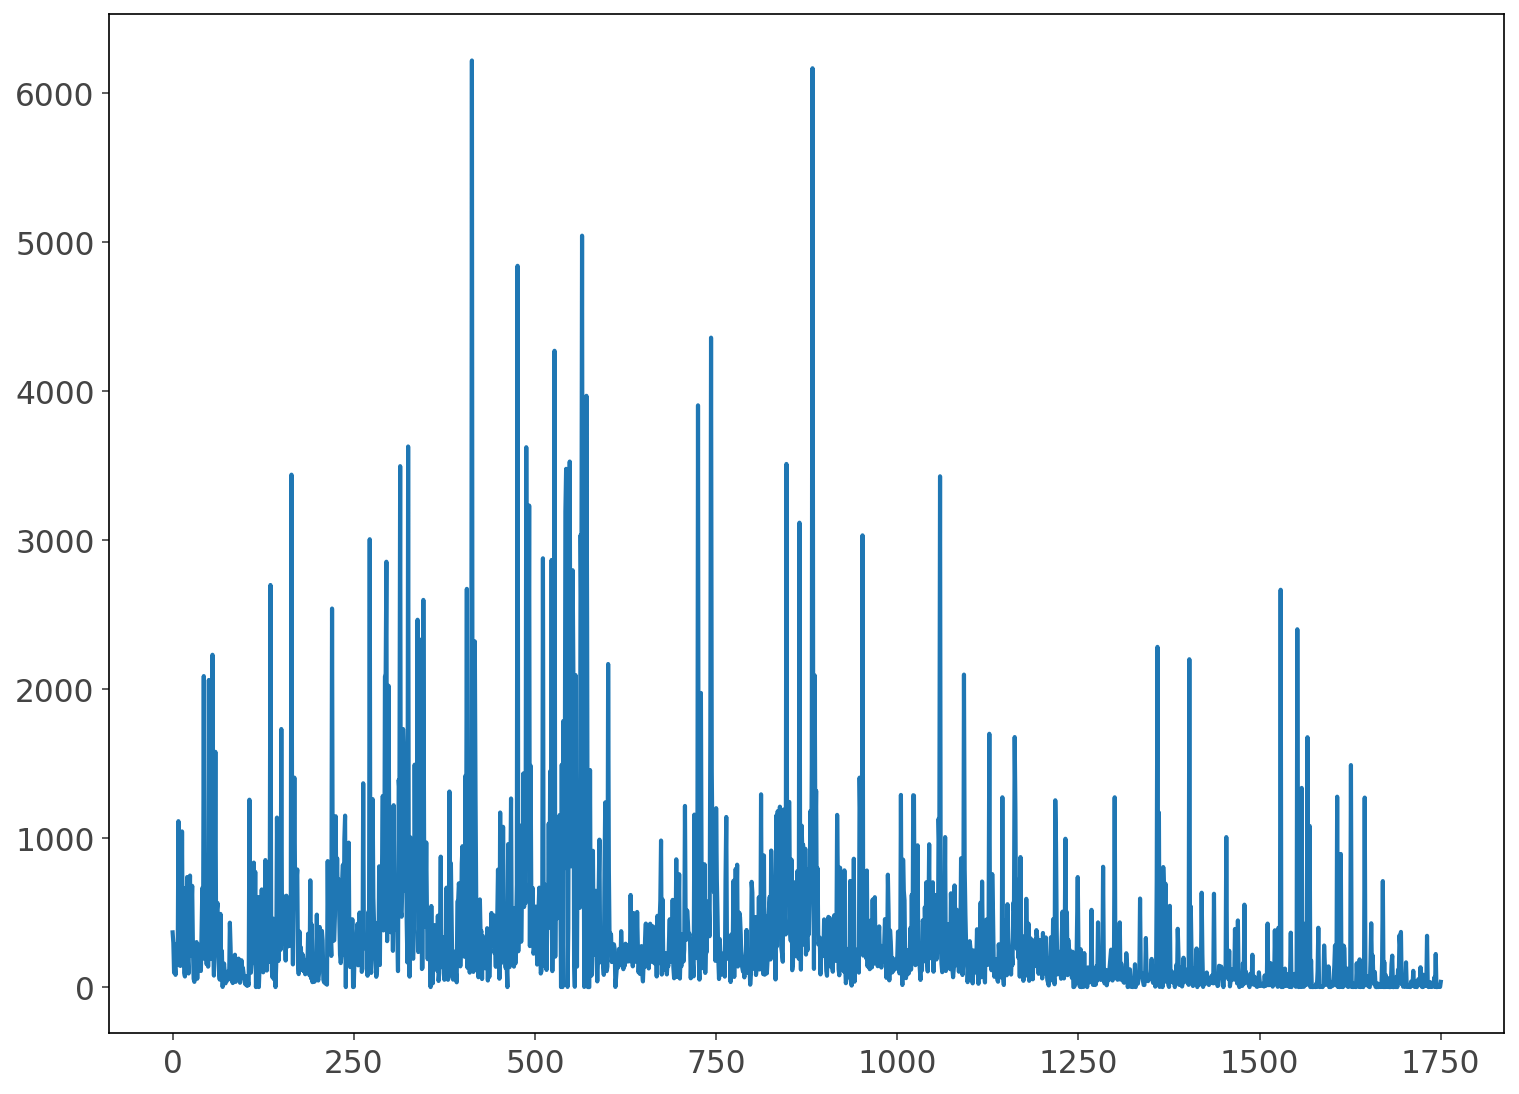

In [19]:
temp_df.nb_trips.plot()

In [20]:
#temp_df.info()

In [21]:
temp_df.head()

,start_lat,start_long,end_lat,end_long,nb_trips
0,37.774814,-122.418954,37.774814,-122.418954,368
1,37.781332,-122.418603,37.774814,-122.418954,297
2,37.790302,-122.390637,37.774814,-122.418954,97
3,37.782259,-122.392738,37.774814,-122.418954,142
4,37.795001,-122.399970,37.774814,-122.418954,83


In [22]:
ave_lat = (temp_df.start_lat.median()+temp_df.end_lat.median())/2
ave_lon = (temp_df.start_long.median()+temp_df.end_long.median())/2

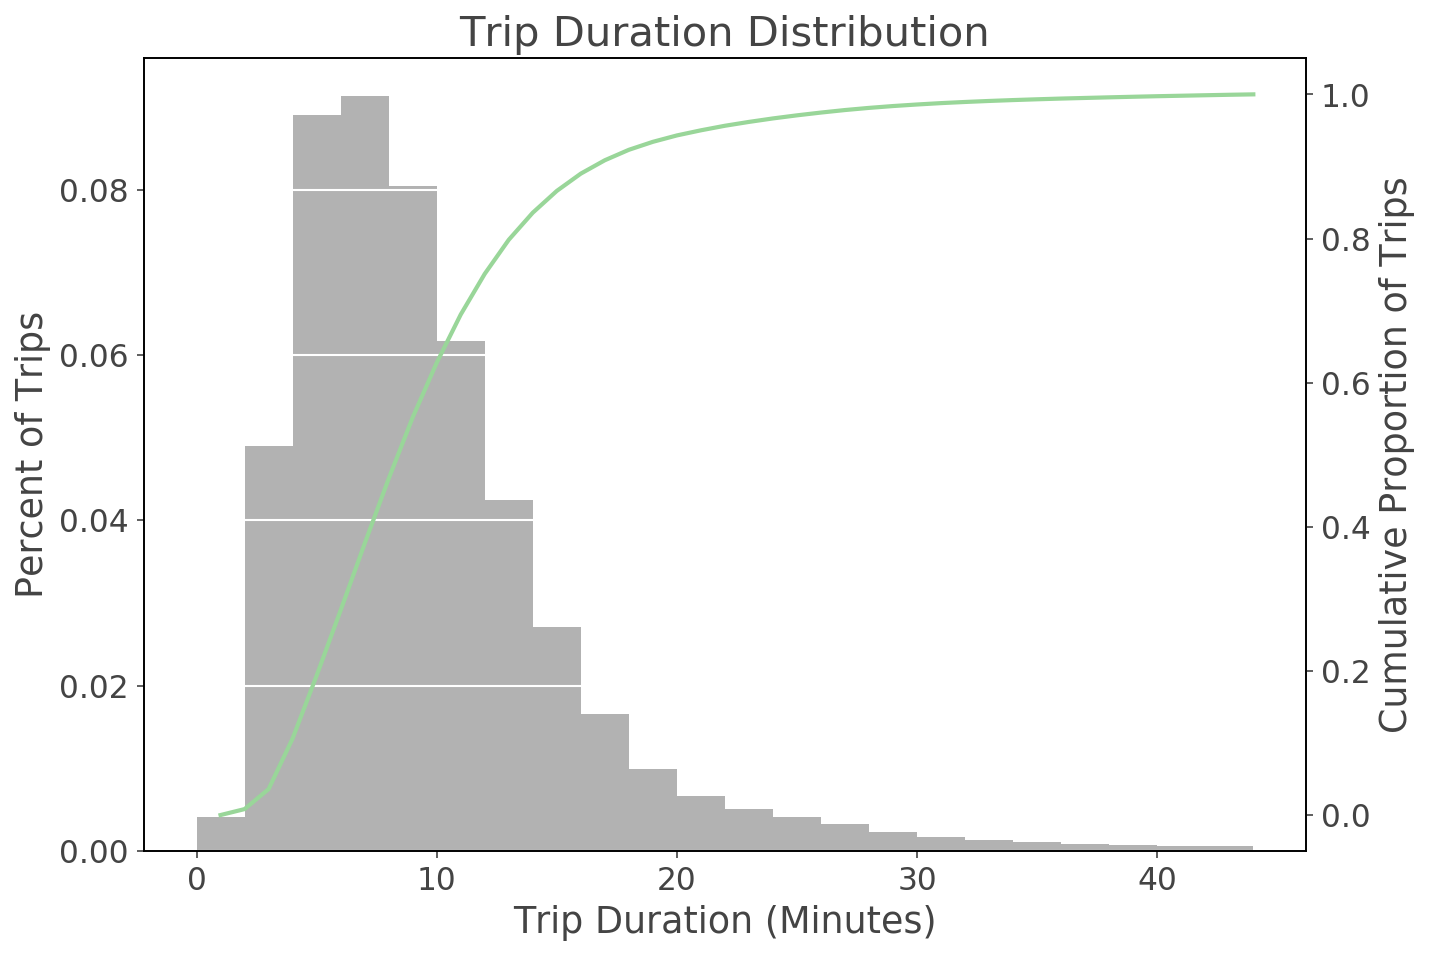

<Figure size 2250x1800 with 0 Axes>

In [26]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.grid(zorder=1)
ax1.xaxis.grid(False)
trip_dur = trips_df['duration'].values/60
plt.hist(trip_dur, bins = range(0,45,2),density=True,zorder=0,color=dark_colors[1])
plt.xlabel('Trip Duration (Minutes)')
plt.ylabel('Percent of Trips')
plt.title('Trip Duration Distribution')
plt.figure(figsize=(15,12))
hist, bin_edges = np.histogram(trip_dur, range(0,45,1), density=True)
cum_trip_dur = np.cumsum(hist)
ax2 = ax1.twinx()
ax2.plot(range(1,45,1),cum_trip_dur,c=dark_colors[0])
ax2.set_ylabel('Cumulative Proportion of Trips')
ax2.grid(b=False)

In [27]:
trips_df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,start_lat,start_long,end_lat,end_long
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,37.774814,-122.418954,37.774814,-122.418954
1,4760,113,2013-08-29 17:01:00,South Van Ness at Market,66,2013-08-29 17:03:00,South Van Ness at Market,66,553,Subscriber,94103,37.774814,-122.418954,37.774814,-122.418954
2,5070,168,2013-08-29 21:43:00,South Van Ness at Market,66,2013-08-29 21:46:00,South Van Ness at Market,66,598,Subscriber,94115,37.774814,-122.418954,37.774814,-122.418954
3,4584,262,2013-08-29 14:17:00,South Van Ness at Market,66,2013-08-29 14:21:00,South Van Ness at Market,66,587,Subscriber,94612,37.774814,-122.418954,37.774814,-122.418954
4,4079,995,2013-08-29 09:35:00,South Van Ness at Market,66,2013-08-29 09:52:00,South Van Ness at Market,66,327,Subscriber,94102,37.774814,-122.418954,37.774814,-122.418954


In [28]:
trips_df['week']=trips_df.start_date.dt.dayofweek
trips_df['start_hour'] = trips_df.start_date.dt.hour
trips_df['start_day'] = trips_df.start_date.dt.day
trips_df['end_hour'] = trips_df.end_date.dt.hour
trips_df['end_day'] = trips_df.end_date.dt.day

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'Trip Duration Distribution Over Time of Day (Week Days)')

<Figure size 2250x1800 with 0 Axes>

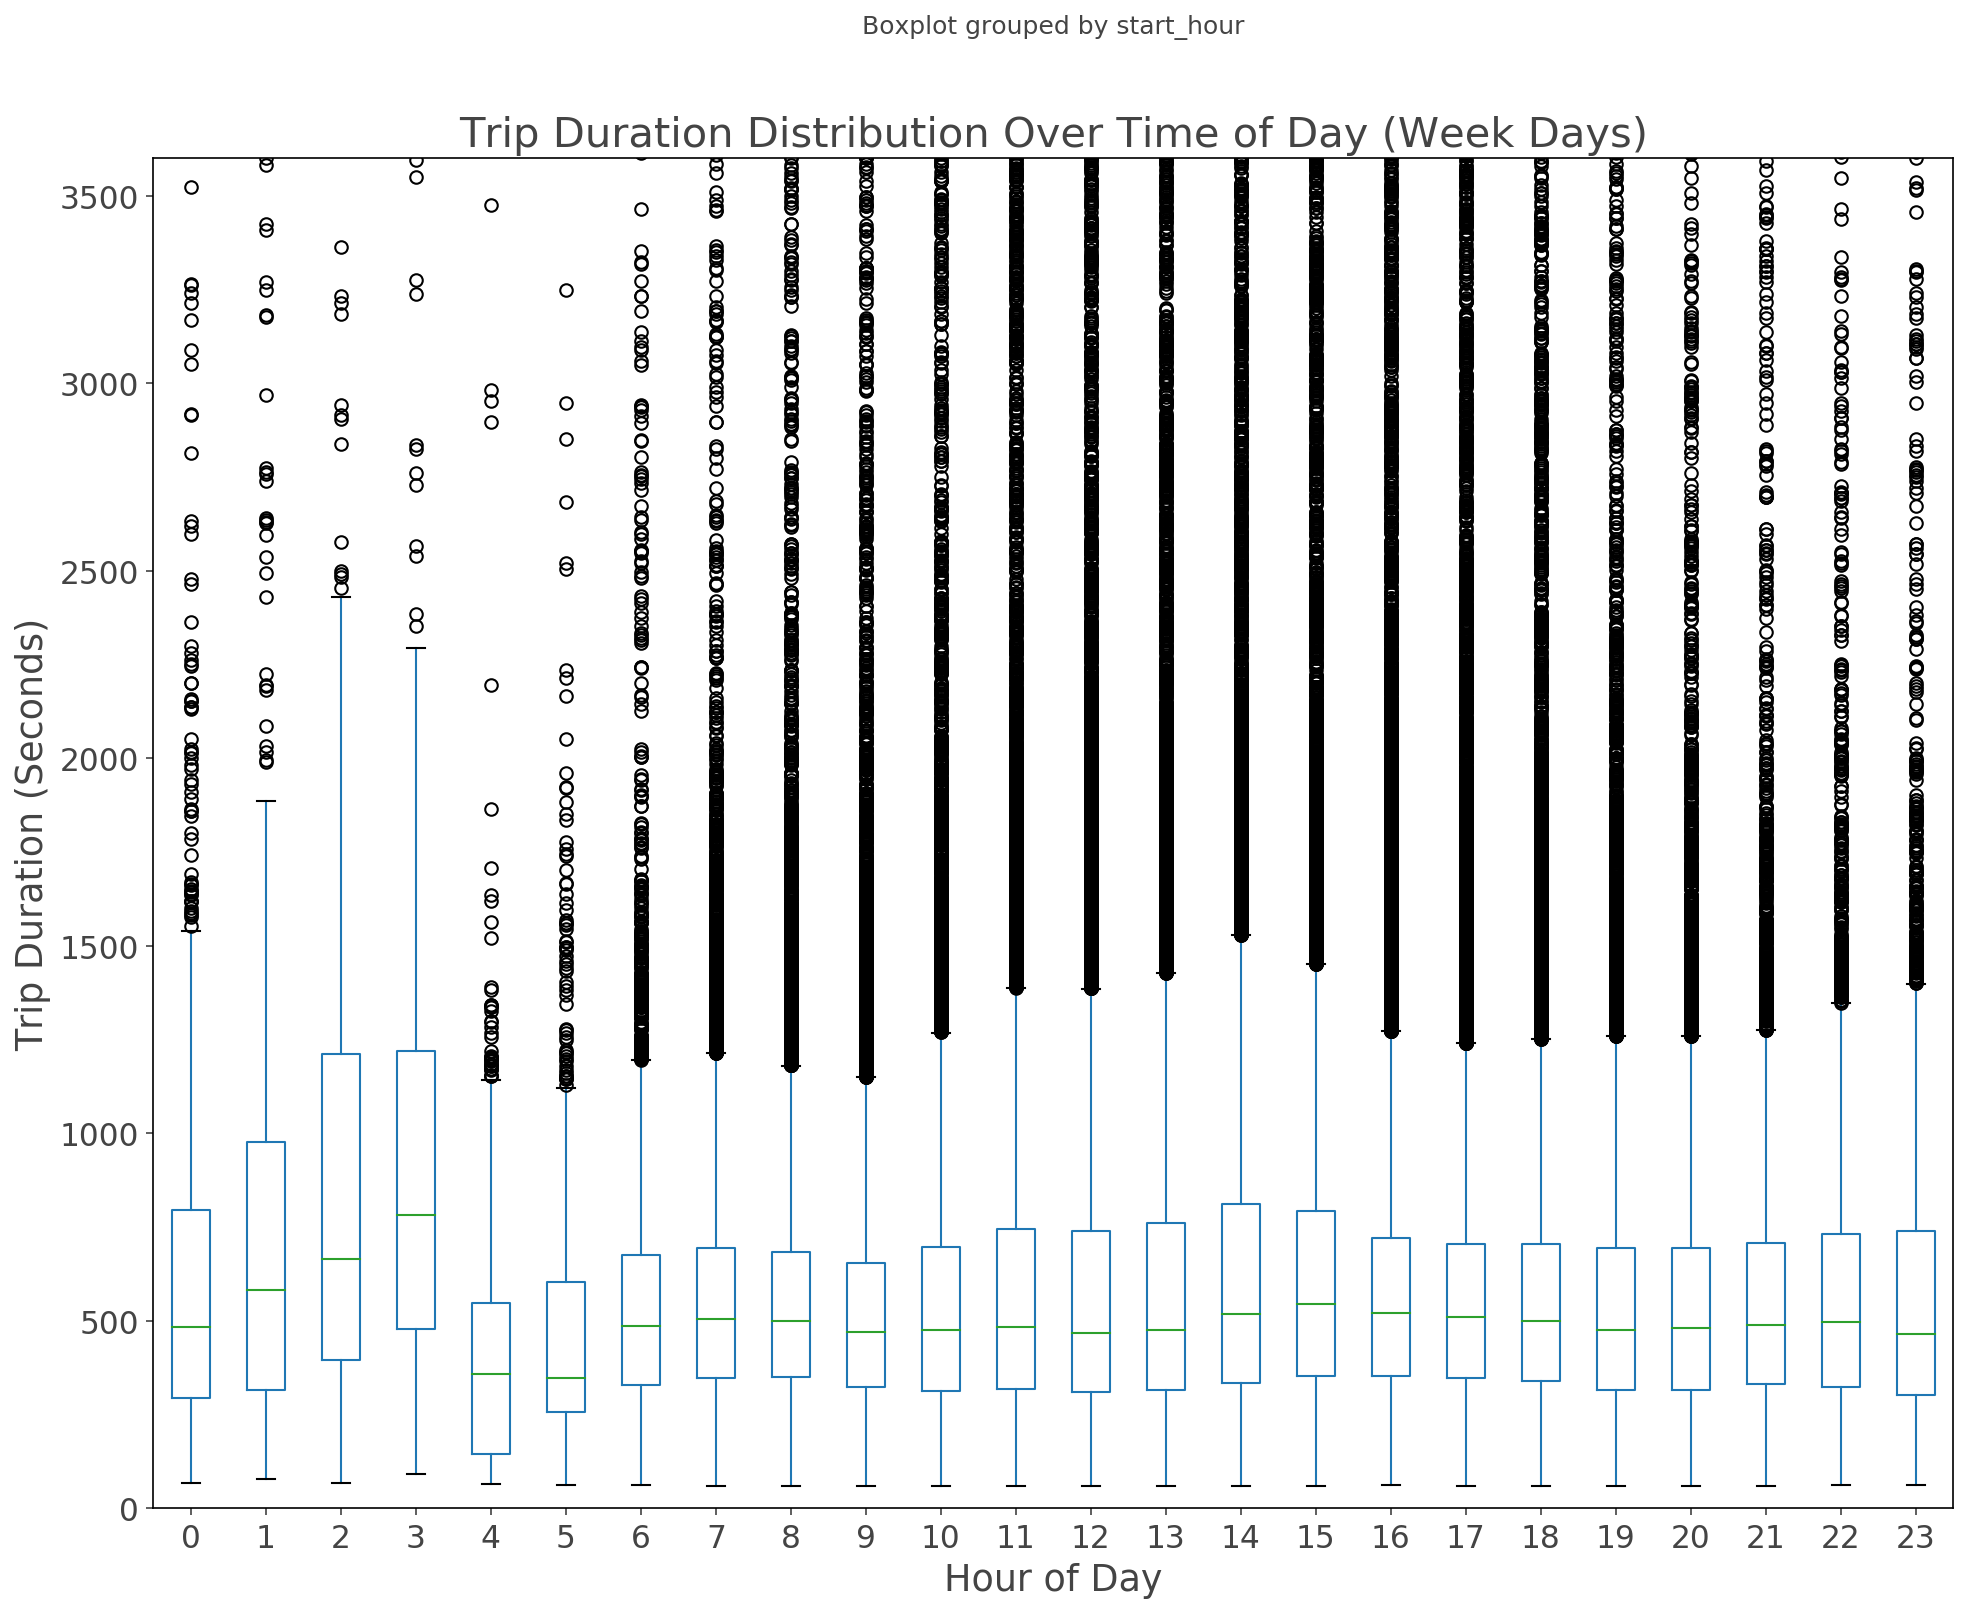

In [29]:
plt.figure(figsize=(15,12))
weekdaytrips_df = trips_df.loc[(trips_df.duration <= 7200) & (trips_df.week <5)]
weekdaytrips_df.boxplot(column="duration",by="start_hour",figsize=(15,12))
plt.ylim(0,3600)
plt.ylabel('Trip Duration (Seconds)')
plt.xlabel('Hour of Day')
plt.title('Trip Duration Distribution Over Time of Day (Week Days)')

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'Trip Duration Distribution Over Time of Day (Weekend days)')

<Figure size 2250x1800 with 0 Axes>

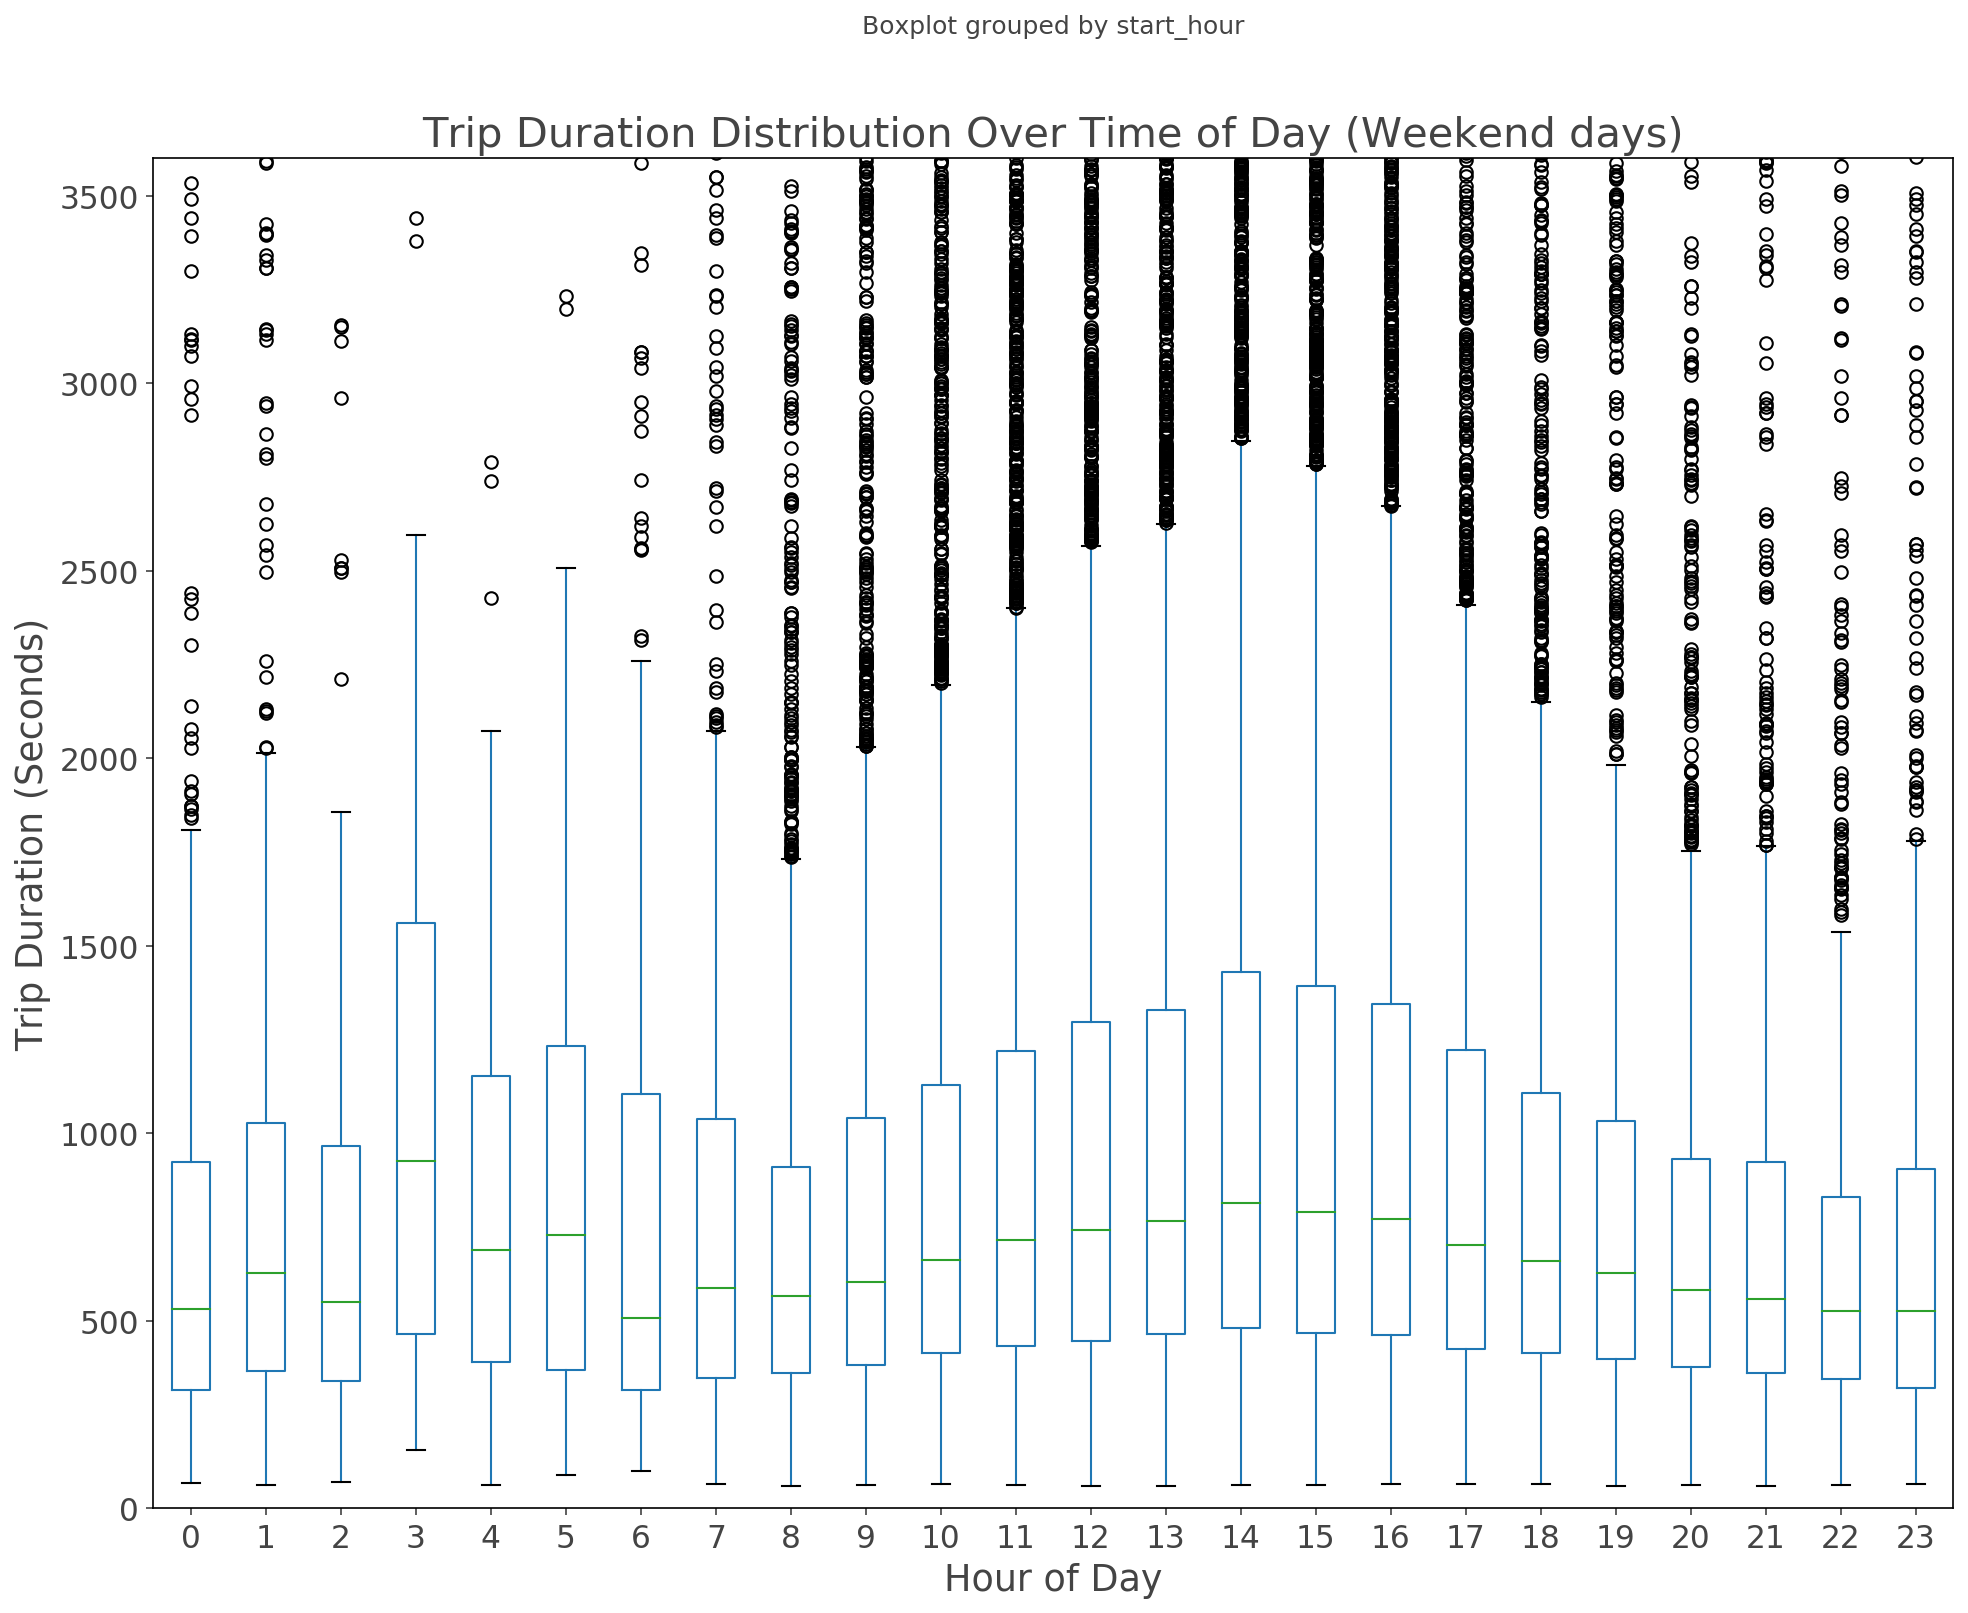

In [30]:
plt.figure(figsize=(15,12))
weekendtrips_df = trips_df.loc[(trips_df.duration <= 7200) & (trips_df.week >4)]
weekendtrips_df.boxplot(column="duration",by="start_hour",figsize=(15,12))
plt.ylim(0,3600)
plt.ylabel('Trip Duration (Seconds)')
plt.xlabel('Hour of Day')
plt.title('Trip Duration Distribution Over Time of Day (Weekend days)')

In [31]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [36]:
status_df = reduce_mem_usage(pd.read_csv('./status.csv'))

Memory usage of dataframe is 2196.79 MB
Memory usage after optimization is: 755.15 MB
Decreased by 65.6%


In [37]:
status_df.head()

,station_id,bikes_available,docks_available,time
0,2,2,25,2013/08/29 12:06:01
1,2,2,25,2013/08/29 12:07:01
2,2,2,25,2013/08/29 12:08:01
3,2,2,25,2013/08/29 12:09:01
4,2,2,25,2013/08/29 12:10:01


In [38]:
status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71984434 entries, 0 to 71984433
Data columns (total 4 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   station_id       int8  
 1   bikes_available  int8  
 2   docks_available  int8  
 3   time             object
dtypes: int8(3), object(1)
memory usage: 755.1+ MB


In [39]:
status_df.time = pd.to_datetime(status_df.time)
status_df = status_df[status_df.time.dt.minute%5 ==0]

In [40]:
stations_df.rename(columns={"id":"station_id"},inplace=True)

In [41]:
stations_df.installation_date = pd.to_datetime(stations_df.installation_date)

In [42]:
status_df = status_df.merge(stations_df,on="station_id",how="left")

In [43]:
status_df.head()

,station_id,bikes_available,docks_available,time,name,lat,long,dock_count,city,installation_date
0,2,2,25,2013-08-29 12:10:01,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06
1,2,2,25,2013-08-29 12:15:01,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06
2,2,2,25,2013-08-29 12:20:01,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06
3,2,2,25,2013-08-29 12:25:01,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06
4,2,2,25,2013-08-29 12:30:01,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06


In [44]:
status_df.reset_index(inplace=True)
status_df.drop(columns=["index"],inplace=True)

In [45]:
status_df["date"] = status_df.time.dt.date

In [46]:
status_df.head()

,station_id,bikes_available,docks_available,time,name,lat,long,dock_count,city,installation_date,date
0,2,2,25,2013-08-29 12:10:01,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06,2013-08-29
1,2,2,25,2013-08-29 12:15:01,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06,2013-08-29
2,2,2,25,2013-08-29 12:20:01,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06,2013-08-29
3,2,2,25,2013-08-29 12:25:01,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06,2013-08-29
4,2,2,25,2013-08-29 12:30:01,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06,2013-08-29


In [47]:
weather_df = reduce_mem_usage(pd.read_csv('./weather.csv'))

Memory usage of dataframe is 0.67 MB
Memory usage after optimization is: 0.24 MB
Decreased by 64.6%


In [48]:
weather_df.date = pd.to_datetime(weather_df.date)

In [49]:
weather_df.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


## Mapping of Zip Codes ans City names
### 95113 - San Jose
### 94301 - Palo Alto
### 94107 - San Francisco

### 94063 - Redwood City
### 94041 - Mountain View


In [50]:
zipcode_city_dict = dict()
zipcode_city_dict[95113] = 'San Jose'
zipcode_city_dict[94301] = 'Palo Alto'
zipcode_city_dict[94107] = 'San Francisco'
zipcode_city_dict[94063] = 'Redwood City'
zipcode_city_dict[94041] = 'Mountain View'

In [51]:
weather_df["city"] = weather_df.zip_code.apply(lambda x:zipcode_city_dict[x])

In [52]:
weather_df.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code,city
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107,San Francisco
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107,San Francisco
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107,San Francisco
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107,San Francisco
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107,San Francisco


In [53]:
status_df.date = pd.to_datetime(status_df.date)

In [54]:
status_df = status_df.merge(weather_df,how="left",on=["date","city"])

In [55]:
status_df.head()

,station_id,bikes_available,docks_available,time,name,lat,long,dock_count,city,installation_date,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2,2,25,2013-08-29 12:10:01,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06,...,10.0,10.0,16.0,7.0,24.0,0,4.0,NaN,320.0,95113
1,2,2,25,2013-08-29 12:15:01,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06,...,10.0,10.0,16.0,7.0,24.0,0,4.0,NaN,320.0,95113
2,2,2,25,2013-08-29 12:20:01,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06,...,10.0,10.0,16.0,7.0,24.0,0,4.0,NaN,320.0,95113
3,2,2,25,2013-08-29 12:25:01,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06,...,10.0,10.0,16.0,7.0,24.0,0,4.0,NaN,320.0,95113
4,2,2,25,2013-08-29 12:30:01,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06,...,10.0,10.0,16.0,7.0,24.0,0,4.0,NaN,320.0,95113


In [56]:
status_df.dropna(inplace=True)

In [57]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [58]:
status_df["events"] = le.fit_transform(status_df["events"])
status_df["precipitation_inches"] = le.fit_transform(status_df["precipitation_inches"])
status_df["name"] = le.fit_transform(status_df["name"])


In [59]:
status_df.head()

,station_id,bikes_available,docks_available,time,name,lat,long,dock_count,city,installation_date,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
954,2,11,16,2013-09-02 00:05:01,54,37.329732,-121.901782,27,San Jose,2013-08-06,...,10.0,10.0,21.0,8.0,25.0,82,5.0,2,315.0,95113
955,2,11,16,2013-09-02 00:10:01,54,37.329732,-121.901782,27,San Jose,2013-08-06,...,10.0,10.0,21.0,8.0,25.0,82,5.0,2,315.0,95113
956,2,11,16,2013-09-02 00:15:01,54,37.329732,-121.901782,27,San Jose,2013-08-06,...,10.0,10.0,21.0,8.0,25.0,82,5.0,2,315.0,95113
957,2,11,16,2013-09-02 00:20:01,54,37.329732,-121.901782,27,San Jose,2013-08-06,...,10.0,10.0,21.0,8.0,25.0,82,5.0,2,315.0,95113
958,2,12,15,2013-09-02 00:25:01,54,37.329732,-121.901782,27,San Jose,2013-08-06,...,10.0,10.0,21.0,8.0,25.0,82,5.0,2,315.0,95113


In [60]:
df = pd.DataFrame(np.random.randn(len(status_df), 1))
msk = np.random.rand(len(df)) < 0.6666
status_df_train = status_df[msk]
status_df_test = status_df[~msk]

In [63]:
train_cols = [c for c in status_df_train.columns if c not in ['time','installation_date','date','city','lat','long','name','bikes_available']]

In [64]:
train_cols.insert(0,'bikes_available')

In [65]:
train_cols

['bikes_available',
 'station_id',
 'docks_available',
 'dock_count',
 'max_temperature_f',
 'mean_temperature_f',
 'min_temperature_f',
 'max_dew_point_f',
 'mean_dew_point_f',
 'min_dew_point_f',
 'max_humidity',
 'mean_humidity',
 'min_humidity',
 'max_sea_level_pressure_inches',
 'mean_sea_level_pressure_inches',
 'min_sea_level_pressure_inches',
 'max_visibility_miles',
 'mean_visibility_miles',
 'min_visibility_miles',
 'max_wind_Speed_mph',
 'mean_wind_speed_mph',
 'max_gust_speed_mph',
 'precipitation_inches',
 'cloud_cover',
 'events',
 'wind_dir_degrees',
 'zip_code']

In [66]:
test_cols = train_cols.copy()

In [194]:
test_cols.remove('bikes_available')

In [195]:
test_cols

['station_id',
 'docks_available',
 'dock_count',
 'max_temperature_f',
 'mean_temperature_f',
 'min_temperature_f',
 'max_dew_point_f',
 'mean_dew_point_f',
 'min_dew_point_f',
 'max_humidity',
 'mean_humidity',
 'min_humidity',
 'max_sea_level_pressure_inches',
 'mean_sea_level_pressure_inches',
 'min_sea_level_pressure_inches',
 'max_visibility_miles',
 'mean_visibility_miles',
 'min_visibility_miles',
 'max_wind_Speed_mph',
 'mean_wind_speed_mph',
 'max_gust_speed_mph',
 'precipitation_inches',
 'cloud_cover',
 'events',
 'wind_dir_degrees',
 'zip_code']

In [69]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-xgboost-churn"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [70]:
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

In [71]:
status_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1539077 entries, 954 to 14409289
Data columns (total 34 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   station_id                      1539077 non-null  int8          
 1   bikes_available                 1539077 non-null  int8          
 2   docks_available                 1539077 non-null  int8          
 3   time                            1539077 non-null  datetime64[ns]
 4   name                            1539077 non-null  int64         
 5   lat                             1539077 non-null  object        
 6   long                            1539077 non-null  object        
 7   dock_count                      1539077 non-null  int64         
 8   city                            1539077 non-null  object        
 9   installation_date               1539077 non-null  datetime64[ns]
 10  date                            1539077

In [90]:
from io import StringIO
bucket = 'agm-temp' # already created on S3
csv_buffer = StringIO()
status_df_train[train_cols].to_csv(csv_buffer, header=False, index = False)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'geo/train/train.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'MBZWPSGBCXX5J8RE',
  'HostId': 'DS1gYfGTpfr9LWfWZAqWKKjf6EOsm2OpwGhFvnl4B5rr7gMwuAAAPpjxoPiK7ysqV1SnZRvuC20=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'DS1gYfGTpfr9LWfWZAqWKKjf6EOsm2OpwGhFvnl4B5rr7gMwuAAAPpjxoPiK7ysqV1SnZRvuC20=',
   'x-amz-request-id': 'MBZWPSGBCXX5J8RE',
   'date': 'Wed, 17 Nov 2021 23:46:55 GMT',
   'etag': '"45a31b4bbb4d30a2a2fe556b329b740b"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"45a31b4bbb4d30a2a2fe556b329b740b"'}

In [91]:
bucket = 'agm-temp' # already created on S3
csv_buffer = StringIO()
status_df_test[train_cols].to_csv(csv_buffer, header=False, index = False)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'geo/test/test.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'KA7SAVE0K68KZM04',
  'HostId': 'HmTKdqkSg7ygodzGabvppvcZvgBsjsEc1cA9B8Zbb5iE+xElhqrb8fvr5HDyT+IDrhGZ47R6ABI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'HmTKdqkSg7ygodzGabvppvcZvgBsjsEc1cA9B8Zbb5iE+xElhqrb8fvr5HDyT+IDrhGZ47R6ABI=',
   'x-amz-request-id': 'KA7SAVE0K68KZM04',
   'date': 'Wed, 17 Nov 2021 23:47:06 GMT',
   'etag': '"e400e552ba3d65c904875a5616e82e9b"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"e400e552ba3d65c904875a5616e82e9b"'}

In [196]:
# Lets generate the files for AutoPilot in the next lab
csv_buffer = StringIO()
status_df_train[train_cols].to_csv(csv_buffer, index = False)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'autopilot/train/train.csv').put(Body=csv_buffer.getvalue())
csv_buffer = StringIO()
status_df_test[test_cols].to_csv(csv_buffer, index = False)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'autopilot/test/test.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '58HAJY2YN3WB7CKX',
  'HostId': 'GIo7XwebMs+SiSaBmZXbq2FCWfZg+0x+AZskgwssfwkD8BRAF8A+UpBxJjQ4c6kmqk4cTOeafbA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'GIo7XwebMs+SiSaBmZXbq2FCWfZg+0x+AZskgwssfwkD8BRAF8A+UpBxJjQ4c6kmqk4cTOeafbA=',
   'x-amz-request-id': '58HAJY2YN3WB7CKX',
   'date': 'Thu, 18 Nov 2021 12:43:20 GMT',
   'etag': '"99b54e5cc5bbd644027eb521232d5280"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"99b54e5cc5bbd644027eb521232d5280"'}

In [92]:
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "latest")
display(container)

'811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest'

In [93]:
prefix = 'geo'
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/test/".format(bucket, prefix), content_type="csv"
)

In [96]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    max_depth=6,
    eval_metric="rmse",
    silent=0,
    objective="reg:linear",
    num_round=100,
)

xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

2021-11-17 23:57:34 Starting - Starting the training job...
2021-11-17 23:57:46 Starting - Launching requested ML instancesProfilerReport-1637193454: InProgress
.........
2021-11-17 23:59:28 Starting - Preparing the instances for training.........
2021-11-18 00:00:48 Downloading - Downloading input data......
2021-11-18 00:01:53 Training - Downloading the training image............
2021-11-18 00:03:49 Training - Training image download completed. Training in progress.[00:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[4]#011train-rmse:1.60979#011validation-rmse:1.60925
[00:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[5]#011train-rmse:1.16044#011validation-rmse:1.15966
[00:03:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[6]#011train-rmse:0.856613#011validation-rmse:0.855516
[00:03:59] src/tree/updater_

In [97]:
xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=CSVSerializer()
)

--------!

In [184]:
for x in range(6):
    random_row=status_df_test[train_cols].sample()
    csv_input = random_row[test_cols].to_csv(header=False,index=False)
    test_bikes_avail = random_row['bikes_available'].to_csv(header=False,index=False)
    predicted_bikes_avail = xgb_predictor.predict(csv_input).decode("utf-8")
    print(f'Test {x} - \n\tPredicted Bike Available \t{predicted_bikes_avail} \n\tActual Bike Available \t\t{test_bikes_avail}')

Test 0 - 
	Predicted Bike Available 	7.000182628631592 
	Actual Bike Available 		7

Test 1 - 
	Predicted Bike Available 	7.999200820922852 
	Actual Bike Available 		8

Test 2 - 
	Predicted Bike Available 	2.00174880027771 
	Actual Bike Available 		2

Test 3 - 
	Predicted Bike Available 	9.01064682006836 
	Actual Bike Available 		9

Test 4 - 
	Predicted Bike Available 	4.010659694671631 
	Actual Bike Available 		4

Test 5 - 
	Predicted Bike Available 	7.995302677154541 
	Actual Bike Available 		8



In [186]:
xgb_predictor.delete_endpoint()

In [ ]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

## There is a lot to be done in feature engineering area using windowing method as this is time series model and the number of bikes at current time depend upon the past available number of bikes like within last 10 minutes and 30 minutes window . I will commit the second version with in short span